In [16]:
import numpy as np
import seaborn as sns
from scipy.linalg import eig
import matplotlib.pyplot as plt 
from modules.LDS import Kalman_EM
from modules.WF_sim import *
from scipy.optimize import minimize

from pathlib import Path

# WF simulation



Total counts shape:  (3, 100)
A is not provide! A_demo is used.
(3, 20, 100)


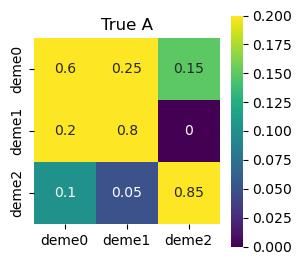

True Neff =  [10000, 10000, 10000]
True measurement noise overdispersion =  [1.0, 1.0, 1.0]
Eigenvalues of A: 
 [1.        +0.j 0.81374586+0.j 0.43625414+0.j]
Eigenvectors of A: 
 [[-0.48507125 -0.18910989  0.80640186]
 [-0.72760688 -0.59332447 -0.51404781]
 [-0.48507125  0.78243436 -0.29235405]]
Check eigvec-eigval relationship: 
 1.0

Lowest left eigenvector of A (normalized):  [0.48507125 0.72760688 0.48507125]
Lowest right eigenvalue of A:     1


In [17]:
ND = 3 # the number of demes 
T=100 # the number of timepoints
Csn =[1.0]*ND # strength of measurement noise overdispersion
Npop = [10000]*ND # effective population size
if ND == 3:
    totcounts=np.array([[2000,3000,1500]]*T).T # number of sequences sampled from each region
elif ND > 3:
    totcounts = np.random.randint(1000, 3000, size=(ND, T))  # random counts for each deme at each timepoint
print("Total counts shape: ", totcounts.shape)

Ntraj = 20 # number of trajectories to simulate
A,counts,B=WF_sim(Npop, totcounts, Csn, ND, T, A=None, Ntraj=Ntraj)
print(counts.shape)
demes=['deme'+str(i) for i in range(ND)]

plt.figure(figsize=[3,3])
sns.heatmap(A,cmap='viridis',vmax=0.2,annot=True,xticklabels=demes, yticklabels=demes,square=True)
plt.title('True A')
plt.show()

print("True Neff = ", Npop)
print("True measurement noise overdispersion = ", Csn )

# find the lowest left eigenvector of A
eigvals, eigvecs = eig(A, left=True, right=False)
# normalize the eigenvectors
eigvecs = eigvecs / np.linalg.norm(eigvecs, axis=0)
eigvec = -eigvecs[:, np.argmax(eigvals.real)]
ordering = np.flip(np.argsort(eigvals.real))
eigvals = eigvals[ordering]
eigvecs = eigvecs[:,ordering]
print("Eigenvalues of A: \n", eigvals)
print("Eigenvectors of A: \n", eigvecs)
# check eigvector-eigenvalue relationship
print("Check eigvec-eigval relationship: \n", eigvec.T @ A @ eigvec)

print("\nLowest left eigenvector of A (normalized): ", eigvec)
print(f"Lowest right eigenvalue of A: {eigvals[np.argmax(eigvals.real)].real:5g}")

# Setting Up Frequencies

In [18]:
freqs = counts / (totcounts[:,None,:]) #calculating frequencies over all trajectories
def freq_setup(freqs):
    f_current=[] #initialise our f(t)
    f_next=[] #initialise our f(t+1)
    for i in range(Ntraj): #make sure we cover all f_i(t) and f_i(t+1)
        for t in range(T-1): #make sure we cover all t
            f_current.append(freqs[:,i,t]) #append with current time
            f_next.append(freqs[:,i,t+1]) #append with next time
    f_current=np.stack(f_current) #convert 1D list into 2D vector comprising of f(t) of all alleles
    f_next=np.stack(f_next) #do the same for f(t+1)
    df=f_next-f_current
    '''print (f_next.shape)'''
    '''print (freqs)'''
    return f_current, f_next, df
'''print (freqs.shape)'''

'print (freqs.shape)'

# Simplified Dynamics to Infer $\pi$ from Minimising Loss Function
Attempt to infer $\pi$ by using \
$f(t+1)=\pi(\pi \cdot f(t))$   
\
$L^\mu_0(t)=|f^\mu(t+1)-\pi (\pi \cdot f^\mu(t))|^2$

In [19]:
# Least squared method that minimizes
# f(t+1) = (pi * f(t))* pi 
# where pi should be the highest left eigenvector
# Loss function:
# L = \sum_t^T (f(t+1) - (pi • f(t)) * pi) •  (f(t+1) - (pi • f(t)) * pi)
# dL/dpi_j = -2(f(t+1)-(pi.f(t))pi)(pi.f(t))-2[(f(t+1)-f(t).pi]f(t)

#define loss function 
#print (counts)


'''print(freqs)'''
def Loss(pi, f_current,f_next): #define Loss function
    L=np.sum((f_next-np.outer((f_current @ pi),pi))**2) # returns L(pi,f)
    return L


def dL_dpi(pi, f_current, f_next): #define dL/dpi to find pi*
    grad=np.zeros_like(pi) #initialise our gradient of L as a bunch of zeros
    for f_t, f_t2 in zip(f_current, f_next): #sum up over all f(t) and f(t+1)
        dot = np.dot(f_t,pi) #define step by step components of equation
        vec=dot*pi 
        err_=f_t2-vec 
        grad+= (-2*(err_)*dot-2*(np.dot(f_t2-f_t,pi))*f_t) #itertively update the gradient
    return grad #give back the gradient


    
def pi_finder(freqs): #want to find out how to minimise L to calculate pi*
    ND, Ntraj, T=freqs.shape #ensure we have recalled number of demes, number of trajectories and time
    '''print(ND, Ntraj, T) #just checking'''
    f_current,f_next, _= freq_setup(freqs)
    pi_guess=np.ones(ND)/ND #creates an initial guess for pi to be used by the minimise function
    #minimise is defined by: (function to be minimised (L), x0 (an initial guess to use), 
    #extra arguments to be used (to be passed through our function and derivitaves), the method to use 
    # (use BFGS iitially as we are dealing with non-linear problem, then SLSQP to support constraints)), jac (the jacobian of L, known), options (dictionary of solver options - set disp to true to print convergence messages)
    #returns minimal pi for L
    # Add constraints: sum(pi) == 1 and pi >= 0
    cons = (
        {'type': 'eq', 'fun': lambda pi: np.sum(pi) - 1},
        #{'type': 'ineq', 'fun': lambda pi: pi}
    )

    result = minimize(
        fun=Loss,
        x0=pi_guess,
        args=(f_current, f_next),
        jac=dL_dpi,
        method='SLSQP',  # SLSQP supports constraints
        constraints=cons,
        options={'disp': True}
    )
    pi_star = result.x #optimal pi
    return pi_star, f_current, f_next 

pi_star, f_t, f_t2=pi_finder(freqs)
print ('pi*=',pi_star)
print(np.sum(pi_star))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.740033471008571
            Iterations: 2
            Function evaluations: 14
            Gradient evaluations: 2
pi*= [0.33334358 0.3298201  0.33683632]
0.9999999999999998


# Attempting to Infer Effective Population
Attempting to use Loss function to infer effective population size using:  \
$f(t+1) \approx \pi (\pi \cdot f(t))+\sqrt{\frac{\pi (\pi \cdot f(t))}{N_e}}$ \
$L^\mu_D=(\frac{\pi}{N_e}\cdot \vec{\mathbf{1}})(\pi\cdot f^\mu(t))$ \
$L=\sum_{\mu, t}(L^\mu_0(t)+L^\mu_D(t))$



In [20]:
#lsr averaged over noise
#L^u(t)=<[f^u(t+1)-pi(pi.f^u(t))-sqrt(pi(pi.f^u(t)/N_{e,i})*nu^u]^2>_{n^u}
#=[f^u(t+1)-pi(pi.f^u(t))]^2+(pi.1)*pi.f^u(t)/N_{e,i} (1 is the unit vector)
#L=sum_{u,t}L^u_t=sum_{u,t}[l^u_o(t)+L^u_D(t)]
#dL/dpi_i=dL_0/dpi_i+sum_{u,t}[pi.f^u(t)+(pi.1)f^u_t(t)]/N_{e,i}
#dL/dN_{e,i}=-sum_{u,t}[(pi.1)*(pi.f^u(t))/N^2_{e,i}]
#can also introduce lambda 'strenth' term in drift terms

def L_new(N_e, pi, f_current, f_next, lamb): #define new loss function 
    L_0 = np.sum((f_next-np.outer((f_current @ pi),pi))**2) #redefine our L_0 from before
    L_D=np.dot(pi/N_e,np.ones_like(pi))*np.sum(f_current @ pi) #now define L_D using equation
    L=L_0+lamb*L_D #sum up both L_0 and L_D
    return L

def dL_dpi_new(pi, f_current, f_next, N_e, lamb): #define our new gradient
    ND=len(pi)
    grad_0=np.zeros_like(pi) 
    for f_t, f_t2 in zip(f_current, f_next): #sum up over all f(t) and f(t+1)
        dot = np.dot(f_t,pi) #define step by step components of equation
        vec=dot*pi 
        err_=f_t2-vec 
        grad_0+= (-2*(err_)*dot-2*(np.dot(f_t2-f_t,pi))*f_t) #itertively update the gradient
    #use same set up as before for grad_0
    dot_new=f_current @ pi #redefine the product f_current . pi
    frac=np.dot(pi/N_e, np.ones_like(pi)) #define (pi/N_e) dot 1
    first_part=(1/N_e)*(np.sum(dot_new)) #define the component 1/N_{e,i} * pi . f^u(t) and sum over u, t
    second_part=frac*np.sum(f_current, axis=0) #define (pi/N_e) . 1 * sum_{u,t} f_i^u(t)
    '''print (len(second_part)) ''' #just checking dimensions are okay
    grad_new=first_part+second_part #add both parts
    grad_total=grad_0+lamb*grad_new #add it all up for the gradient (introduce lambda factor)
    return grad_total

def dL_dN_e(N_e, pi, f_current, f_next, lamb):
    
    grad_Ne=-(pi/N_e**2)*np.sum(f_current @ pi)
    return lamb*grad_Ne


In [21]:
def N_e_finder(freqs, pi): #just for trial one, use scipy minimize in a similar fashion to finding pi
    lamb=1.0
    f_current, f_next,_ = freq_setup(freqs)
    ND, Ntraj, T = freqs.shape
    
    N_e_guess=np.ones(ND)

    result = minimize(
        fun=L_new,
        x0=N_e_guess,
        args=(pi, f_current, f_next, lamb),
        jac=dL_dN_e,
        method='BFGS',  
        options={'disp': True}
    )
    N_e_star = result.x #optimal N_e
    return N_e_star, f_current, f_next 
N_e, _, _ =N_e_finder(freqs, pi_star) #use pi* from before
print (N_e)
print(pi_star)

Optimization terminated successfully.
         Current function value: 9.771084
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31
[3678.37639127 2263.11372904 4371.86236673]
[0.33334358 0.3298201  0.33683632]


In [22]:

def L_combo(combo, f_current, f_next, lamb): #define combo loss function
    ND=f_current.shape[1]
    pi=combo[:ND] #bring pi out of combo 
    N_e=combo[ND:] #bring N_e out of combo

    #pi=pi/np.sum(pi) #ensure normalisation of pi

    L_0 = np.sum((f_next-np.outer((f_current @ pi),pi))**2) #redefine our L_0 from before
    L_D=np.dot(pi/N_e,np.ones_like(pi))*np.sum(f_current @ pi) #now define L_D using equation
    L=L_0+lamb*L_D #sum up both L_0 and L_D
    return L

def grad_combo(combo, f_current, f_next, lamb): #define combo gradient
    ND=f_current.shape[1]
    pi=combo[:ND]
    N_e=combo[ND:]
    #pi=pi/np.sum(pi)

    grad_pi=dL_dpi_new(pi, f_current, f_next, N_e, lamb)
    grad_Ne=-(pi/N_e**2)*np.sum(f_current @ pi)
    
    grad_total=np.concatenate([grad_pi, grad_Ne])

    return grad_total

def optimiser(freqs):
    lamb=1.0
    ND, Ntraj, T=freqs.shape
    max_N_e=np.ones(ND)*20000
    N_e_guess=np.ones(ND)
    pi_guess=np.ones(ND)/ND
    f_current, f_next,_ = freq_setup(freqs)
    print (f_current.shape)
    combo_guess=np.concatenate([pi_guess,N_e_guess])
    cons = (
        {'type': 'eq', 'fun': lambda combo: np.sum(combo[:ND]) - 1},
        {'type': 'ineq', 'fun': lambda combo: combo[:ND]},
        {'type': 'ineq', 'fun': lambda combo: combo[ND:]-1e-6}, #ensure N_e>0
        {'type':'ineq', 'fun' : lambda combo: max_N_e - combo[ND:]}
    )
    result = minimize(
        fun=L_combo,
        x0=combo_guess,
        args=(f_current, f_next, lamb),
        jac=grad_combo,
        method='SLSQP',  # SLSQP supports constraints
        constraints=cons,  
        options={'disp': True}
    )

    combo_star=result.x
    pi_star=combo_star[:ND]
    #pi_star /= np.sum (pi_star)
    N_e_star=combo_star[ND:]

    return pi_star, N_e_star

pi_star, N_e_star=optimiser(freqs)
print ('pi*=',pi_star)
print ('sum of pi* is',np.sum(pi_star))
print ('N_e*=', N_e_star)

(1980, 3)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.745594883203768
            Iterations: 33
            Function evaluations: 37
            Gradient evaluations: 33
pi*= [0.33332185 0.33079339 0.33588475]
sum of pi* is 1.0000000000000002
N_e*= [16988.0617317  17467.05815227 20000.        ]


# Checking Accuracies and Bootstrapping

In [23]:

def pi_checker(pi,f_current,f_next): #want to now see how close we are
    dot= f_current @ pi  #gives us f(t).pi
    calc=np.outer(dot,pi) #gives us {f(t).pi}pi (=f(t+1))
    err=f_next-calc #gives us the error 
    err2=np.mean(err**2) #gives us mean squared error
    return err2, calc, err
f_t, f_t2, _ = freq_setup(freqs)
err2, calc, err = pi_checker(pi_star, f_t, f_t2)
#print (err2)
print (err)
print (err2)
print (np.sqrt(err2))
print(f_t @ pi_star)
print ("---")
print (f_t2)

[[0.02815137 0.05599136 0.07830902]
 [0.04031483 0.04284301 0.05945068]
 [0.05157897 0.03609755 0.06072453]
 ...
 [0.08621285 0.07485558 0.0755659 ]
 [0.0716114  0.09108064 0.08447136]
 [0.08374717 0.07455631 0.07426716]]
0.0016397492922566293
0.04049381795109754
[0.06854826 0.07705815 0.07326562 ... 0.12236567 0.11966993 0.12226269]
---
[[0.051      0.07866667 0.10133333]
 [0.066      0.06833333 0.08533333]
 [0.076      0.06033333 0.08533333]
 ...
 [0.127      0.11533333 0.11666667]
 [0.1115     0.13066667 0.12466667]
 [0.1245     0.115      0.11533333]]


In [24]:
#bootstrapping 
#essential idea of bootstrapping - trying to generate new data sets, same size as original, to create prob distribution of mean and s.d.
n_B = 1000 #number of bootstraps
def bootstrapping(freqs, n_B, seed=None): #paramterise by the frequency, number of bootstraps, and seed (used in random nummber generator)
    Nd, Ntraj, T = freqs.shape 
    numb=np.random.default_rng(seed) #ensures numbers are randomly generated all the time

    ps = [] #initialise list

    for b in range(n_B): #iterate over bootstrap numbers
        n_traj_new=numb.choice(Ntraj, size=Ntraj, replace=True) #generates a new array of random trajectories to use to 'shuffle around' frequencies
        freqs_bootstrap = freqs[:,n_traj_new,:] #creates bootstrapped frequency data sets

        #now run existing pi finder

        try: 
            pi_new, _, _ = pi_finder(freqs_bootstrap) #apply pi finder to new frequency
            ps.append(pi_new) #append list
        except Exception as e: #check for errors 
            print(f'{b} failed: {e}')
        if b % 100 == 0:
            print(f'Bootstrap {b}/{n_B}') #check for what stage we're at for large n_B
    ps=np.stack(ps) #turns list into matrix of pi vectors at differen boot straps

    

    ps_mean=np.mean(ps, axis=0) #gives the mean
    ps_std=np.std(ps, axis=0) #gives the standard deviation
    ps_lower=np.percentile(ps, 2.5, axis=0)
    ps_upper=np.percentile(ps, 97.5, axis=0) #gives confidence interva;
    return ps, ps_mean, ps_std, ps_lower, ps_upper

pis, pis_mean, pis_std, pis_lower, pis_upper = bootstrapping(freqs, n_B)
print (pis_mean)
print ("------")
print (pis_std)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.113385952937964
            Iterations: 2
            Function evaluations: 14
            Gradient evaluations: 2
Bootstrap 0/1000
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10.702985010401106
            Iterations: 2
            Function evaluations: 14
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.46651623425713
            Iterations: 2
            Function evaluations: 14
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.995400640272154
            Iterations: 2
            Function evaluations: 14
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: 11.025909565911867
            Iterations: 2
            Functio

In [25]:

f_t, f_t2, df=freq_setup(freqs)
#print(freqs.shape)
#print(np.sum(f_t, axis=0).shape)
#set up to prepare for lsr
print(eigvec)
def set_up_lsr(freqs, lamb):
    _, _, df=freq_setup(freqs)
    ND, _, _ = freqs.shape
    A=df.T @ df / ND
    y=lamb*np.ones(ND)
    return A, y

def lsr_numpy(freqs, lamb):
    A, y=set_up_lsr(freqs, lamb)
    pi, residuals, rank, s = np.linalg.lstsq(A, y, rcond=None)
    pi /= np.sum(pi)
    return pi

def error_checker_numpy(freqs, lamb):
        pi=lsr_numpy(freqs, lamb)
        f_t, f_t2, _ = freq_setup(freqs)
        #print (pi.shape)
        #print (f_t.shape)
        err=(f_t2-f_t)@pi
        err2=np.mean(err**2)
        err_rms=np.sqrt(err2)
        return err, err2, err_rms
def error_checker_matrix(freqs):
    pi=eigvec/np.sum(eigvec)
    f_t, f_t2, _ = freq_setup(freqs)
    #print (pi.shape)
    #print (f_t.shape)
    err=(f_t2-f_t)@pi
    err2=np.mean(err**2)
    err_rms=np.sqrt(err2)
    return err, err2, err_rms, pi
i=0.1
j=10.0
pi_1=lsr_numpy(freqs, i)
pi_2=lsr_numpy(freqs, j)
print(f"Dfference between lambda={i} and lambda={j} is: {pi_1-pi_2}")
pi_star=lsr_numpy(freqs, lamb=3.0)
err, err2, err_rms=error_checker_numpy(freqs, lamb=3.0)

print('pi* (linear regression)=', pi_star)
print(f'sum of pi* is:{np.sum(pi_star)}')
print('MSE (linear regression)=', err2)
print('RMSE (linear regression)=', err_rms)
err_mat, mse_mat, rms_mat, pi_mat=error_checker_matrix(freqs)

print(f'pi* (matrix)={pi_mat}')
print(f'sum of pi* (matrix) is:{np.sum(pi_mat)}')
print(f'MSE (matrix) is {mse_mat}')
print(f'RMSE (matrix) is {rms_mat}')

print(f'Difference in error between methods is {rms_mat-err_rms}')

[0.48507125 0.72760688 0.48507125]
Dfference between lambda=0.1 and lambda=10.0 is: [-1.11022302e-16  5.55111512e-17  0.00000000e+00]
pi* (linear regression)= [0.32119866 0.43346264 0.2453387 ]
sum of pi* is:1.0
MSE (linear regression)= 1.5388861681312863e-05
RMSE (linear regression)= 0.003922863964160988
pi* (matrix)=[0.28571429 0.42857143 0.28571429]
sum of pi* (matrix) is:1.0
MSE (matrix) is 1.5586798827275015e-05
RMSE (matrix) is 0.003948012009515044
Difference in error between methods is 2.514804535405559e-05


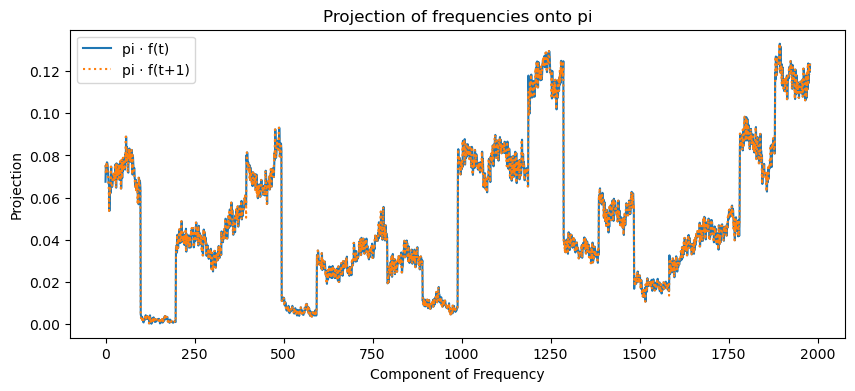

In [26]:
import matplotlib.pyplot as plt

f_t, f_t2, _ = freq_setup(freqs)
proj_t = f_t @ pi_star
proj_t2 = f_t2 @ pi_star

plt.figure(figsize=(10,4))
plt.plot(proj_t, label='pi · f(t)')
plt.plot(proj_t2, label='pi · f(t+1)', linestyle=':')
plt.xlabel('Component of Frequency')
plt.ylabel('Projection')
plt.legend()
plt.title('Projection of frequencies onto pi')
plt.show()

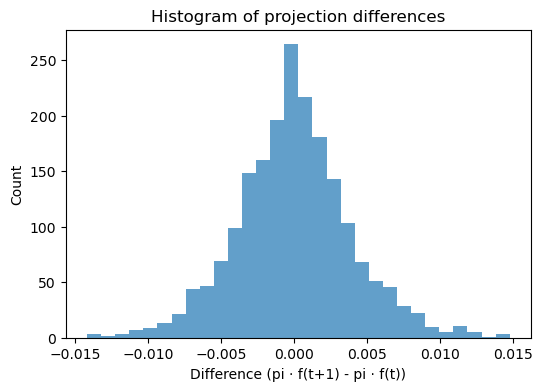

In [27]:
diff = proj_t2 - proj_t
plt.figure(figsize=(6,4))
plt.hist(diff, bins=30, alpha=0.7)
plt.xlabel('Difference (pi · f(t+1) - pi · f(t))')
plt.ylabel('Count')
plt.title('Histogram of projection differences')
plt.show()

Slope of graph is 0.0038444066848777685


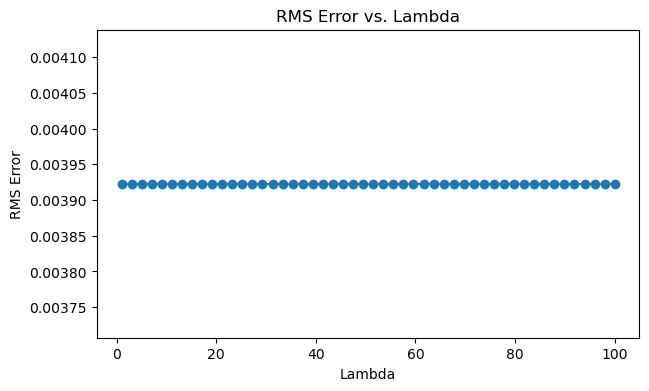

In [28]:
lambdas = np.linspace(1, 100, 50)
rms_errors = []

for lamb in lambdas:
    _, _, err_rms = error_checker_numpy(freqs, lamb)
    rms_errors.append(err_rms)
print(f"Slope of graph is {rms_errors[-1]-rms_errors[0]/len(lambdas)}")
plt.figure(figsize=(7,4))
plt.plot(lambdas, rms_errors, marker='o')
plt.xlabel('Lambda')
plt.ylabel('RMS Error')
plt.title('RMS Error vs. Lambda')
plt.show()